In [33]:
import SimpleITK as sitk
import numpy as np
import torch
import pandas as pd
import monai.metrics as met
import os, nrrd

In [2]:
data = data = pd.read_csv('/Users/joemarsilla/Downloads/structseg.csv', index_col=0)

In [3]:
data.head()

,0,1
0,/cluster/projects/radiomics/PublicDatasets/Hea...,/cluster/projects/radiomics/PublicDatasets/Hea...
1,/cluster/projects/radiomics/PublicDatasets/Hea...,/cluster/projects/radiomics/PublicDatasets/Hea...
2,/cluster/projects/radiomics/PublicDatasets/Hea...,/cluster/projects/radiomics/PublicDatasets/Hea...
3,/cluster/projects/radiomics/PublicDatasets/Hea...,/cluster/projects/radiomics/PublicDatasets/Hea...
4,/cluster/projects/radiomics/PublicDatasets/Hea...,/cluster/projects/radiomics/PublicDatasets/Hea...


In [4]:
pats = list(data['0'])

In [5]:
p = [p.split('/')[-2] for p in pats]

In [105]:
p = list(set(p))

In [6]:
from collections import OrderedDict
p = OrderedDict((x, True) for x in p).keys()

In [7]:
p = list(p)

In [8]:
p

['37',
 '19',
 '17',
 '46',
 '25',
 '35',
 '6',
 '18',
 '34',
 '42',
 '44',
 '24',
 '2',
 '21',
 '48',
 '20',
 '23',
 '14',
 '8',
 '3',
 '27',
 '5',
 '11',
 '15',
 '7',
 '28',
 '40',
 '13',
 '30',
 '12',
 '16',
 '26',
 '32',
 '36',
 '50',
 '9',
 '39',
 '45',
 '4',
 '41',
 '43',
 '22',
 '10',
 '29',
 '1',
 '49',
 '38',
 '33',
 '31',
 '47']

In [9]:
img = sitk.ReadImage('/Users/joemarsilla/Downloads/HaN_OAR/1/label.nii.gz')

In [11]:
img = sitk.GetArrayFromImage(img)

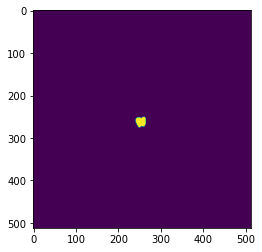

In [14]:
import matplotlib.pyplot as plt
plt.imshow(img[100]==1)

In [15]:
deep_classes = ['Brain_Stem','Eye_L','Eye_R','Lens_L','Lens_R','Opt_Nerve_L','Opt_Nerve_R','Opt_Chiasma','Temporal_Lobes_L', 'Temporal_Lobes_R','Pituitary','Parotid_Gland_L','Parotid_Gland_R','Inner_Ear_L','Inner_Ear_R','Mid_Ear_L','Mid_Ear_R', 'T_M_Joint_L','T_M_Joint_R','Spinal_Cord','Mandible_L','Mandible_R']
cname = ['Brain_Stem', 'Spinal_Cord', 'Mandible_L','Mandible_R', 'Parotid_Gland_L','Parotid_Gland_R', 'Inner_Ear_L','Inner_Ear_R','Mid_Ear_L','Mid_Ear_R','Lens_L','Lens_R','Eye_L','Eye_R', 'Opt_Nerve_L','Opt_Nerve_R', 'Opt_Chiasma']
index_ = [1,2,5,5,6,7,8,9,8,9,12,13, 14, 15, 16, 17, 18]
chosen = ['BSTEM','SPCOR','ESOPH','LARYNX','MAND','LPAR','RPAR','LACOU','RACOU','RPLEX','LPLEX','LLENS','RLENS','LEYE','REYE','LOPTIC','ROPTIC','CHIASM','LIPS']

In [26]:
s_index = [deep_classes.index(c)+1 for c in cname]

In [27]:
s_index

[1, 20, 21, 22, 12, 13, 14, 15, 16, 17, 4, 5, 2, 3, 6, 7, 8]

In [18]:
len(s_index)==len(index_)

True

In [19]:
# import torch, numpy as np, warnings
# this is the function to one-hot-encode data
def onehot(outs, targ, argmax=True):
    # Metrics requiring one hot encoded targets, pass through sigmoid or softmax
    # convert to one hot encoded target...
    shape = targ.size()
    print(len(shape), shape, outs.size())
    batch = shape[0]
    # calculate argmax...
    if argmax is True:
        outs = torch.softmax(outs, dim=1)
        outs = torch.argmax(outs, dim=1)
    
    class_ = int(torch.max(targ).item())
    print(class_)
    
    if len(shape) == 4:
        sh = (batch, class_ + 1, shape[1], shape[2], shape[3])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)
    else:
        sh = (1, class_ + 1, shape[0], shape[1], shape[2])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)

    for i in range( class_ + 1):
        targets_dice[0, i][targ[0] == i] = 1
        targets_out[0, i][outs[0] == i] = 1

    return targets_out, targets_dice


In [20]:
def resample_sitk(image, mode="linear", new_spacing=None, filter=False ): # new_spacing=np.array((1.0, 1.0, 2.0)) , filter=True
    if new_spacing is not None: # originally taken from https://github.com/SimpleITK/SimpleITK/issues/561
        resample = sitk.ResampleImageFilter()
        if mode == "linear":
            resample.SetInterpolator = sitk.sitkLinear  # use linear to resample image
        else: # use sitkNearestNeighbor interpolation # best for masks
            resample.SetInterpolator = sitk.sitkNearestNeighbor
        orig_size = np.array(image.GetSize(), dtype=np.int)
        orig_spacing = np.array(image.GetSpacing())
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(image.GetOrigin())
        resample.SetOutputPixelType(image.GetPixelIDValue())
        new_spacing = new_spacing
        resample.SetOutputSpacing(new_spacing)
        new_size = orig_size * (orig_spacing / new_spacing)
        new_size = np.ceil(new_size).astype(np.int)
        new_size = [int(s) for s in new_size]
        resample.SetSize(new_size)
        if filter is True: # fights artifacts produced by analaising # only do this when resampling image (not mask...)
            img = resample.Execute(sitk.SmoothingRecursiveGaussian(image, 2.0))
        else:
            img = resample.Execute(image)
    else: # do nothing to the image...
        img = image
    return img

In [48]:
oars = []
struct_oars = []
dce =  []
hd =   []
sd =   []
p_ = []

In [49]:
# path of folders...
observer = 'radiographer'
path = f'/Users/joemarsilla/Downloads/HaN_OAR/' 
# os.mkdir(path)
for i, pat in enumerate(p):
    path_ = path+pat+'/label.nii.gz'
    # load subsequent patient outputs from model...
    out_path = f"/Users/joemarsilla/Downloads/struct/FINAL_/outs_{i}_FULL.nrrd"
    outputs = nrrd.read(out_path)[0]
    outputs = torch.from_numpy(outputs)
    targ = sitk.ReadImage(path_)
    targ = torch.from_numpy(sitk.GetArrayFromImage(targ))
    targ[targ>21]=21
    outputs, _ = onehot(outputs.unsqueeze(0), outputs.unsqueeze(0), argmax=False)
    targ, _ = onehot(targ.unsqueeze(0), targ.unsqueeze(0), argmax=False)
    
    for k, val in enumerate(index_):
        if s_index[k] == 22:
            pass
        else:
            outs = outputs[0,val]
            tar = targ[0, s_index[k]]
            tsize = tar.size()
            print(tsize)
            osize = outs.size()
            if osize[0] != tsize[0]:
                diff = osize[0] - tsize[0]
                a = diff//2
                difff = diff - a
                outs = outs[a:osize[0]-difff]
                osize = outs.size()
                assert osize[0] == tsize[0]
            print(osize)
            if osize[0]>tsize[0]:
                diff = osize[0] - tsize[0]
                a = diff//2
                difff = diff - a
                outs = outs[a:osize[0]-difff]
            dc = met.compute_meandice(outs.unsqueeze(0).unsqueeze(0), tar.unsqueeze(0).unsqueeze(0))
            h  = met.compute_hausdorff_distance(outs.unsqueeze(0).unsqueeze(0), tar.unsqueeze(0).unsqueeze(0), percentile=95, include_background=False)
            s  = met.compute_average_surface_distance(outs.unsqueeze(0).unsqueeze(0), tar.unsqueeze(0).unsqueeze(0), include_background=False)
            print(chosen[val-1], dc, h)
            # save metrics...
            dce.append(dc[0][0].item())
            hd.append(h[0][0].item())
            sd.append(s[0][0].item())
            struct_oars.append(cname[k])
            oars.append(chosen[val-1])
            p_.append(pat)
        

4 torch.Size([1, 112, 512, 512]) torch.Size([1, 112, 512, 512])
19
(1, 20, 112, 512, 512)
4 torch.Size([1, 112, 512, 512]) torch.Size([1, 112, 512, 512])
21
(1, 22, 112, 512, 512)
torch.Size([112, 512, 512])
torch.Size([112, 512, 512])
BSTEM tensor([[0.8117]]) tensor([[3.]], dtype=torch.float64)
torch.Size([112, 512, 512])
torch.Size([112, 512, 512])
SPCOR tensor([[0.7689]]) tensor([[2.4495]], dtype=torch.float64)
torch.Size([112, 512, 512])
torch.Size([112, 512, 512])
MAND tensor([[0.7557]]) tensor([[6.4031]], dtype=torch.float64)
torch.Size([112, 512, 512])
torch.Size([112, 512, 512])
LPAR tensor([[0.8767]]) tensor([[2.2361]], dtype=torch.float64)
torch.Size([112, 512, 512])
torch.Size([112, 512, 512])
RPAR tensor([[0.8949]]) tensor([[2.2361]], dtype=torch.float64)
torch.Size([112, 512, 512])
torch.Size([112, 512, 512])
LACOU tensor([[0.5296]]) tensor([[4.4721]], dtype=torch.float64)
torch.Size([112, 512, 512])
torch.Size([112, 512, 512])
RACOU tensor([[0.4781]]) tensor([[5.9161]], d

/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/hausdorff_distance.py:160: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/anaconda3/lib/python3.9/site-packages/monai/metrics/surface_distance.py:155: UserWarning: the prediction of class 0 is all 0, this may result in nan/inf distance.
  warnings.warn(f"the prediction of class {c} is all 0, this may result in nan/inf distance.")


CHIASM tensor([[0.]]) tensor([[nan]], dtype=torch.float64)
4 torch.Size([1, 112, 512, 512]) torch.Size([1, 112, 512, 512])
19
(1, 20, 112, 512, 512)
4 torch.Size([1, 105, 512, 512]) torch.Size([1, 105, 512, 512])
21
(1, 22, 105, 512, 512)
torch.Size([105, 512, 512])
torch.Size([105, 512, 512])
BSTEM tensor([[0.7779]]) tensor([[3.7417]], dtype=torch.float64)
torch.Size([105, 512, 512])
torch.Size([105, 512, 512])
SPCOR tensor([[0.6212]]) tensor([[2.4495]], dtype=torch.float64)
torch.Size([105, 512, 512])
torch.Size([105, 512, 512])
MAND tensor([[0.8171]]) tensor([[5.1962]], dtype=torch.float64)
torch.Size([105, 512, 512])
torch.Size([105, 512, 512])
LPAR tensor([[0.8240]]) tensor([[3.6056]], dtype=torch.float64)
torch.Size([105, 512, 512])
torch.Size([105, 512, 512])
RPAR tensor([[0.9007]]) tensor([[2.]], dtype=torch.float64)
torch.Size([105, 512, 512])
torch.Size([105, 512, 512])
LACOU tensor([[0.5066]]) tensor([[5.]], dtype=torch.float64)
torch.Size([105, 512, 512])
torch.Size([105, 5

torch.Size([112, 512, 512])

In [39]:
targ.shape

torch.Size([1, 23, 112, 512, 512])

In [26]:
len(oars)

840

In [51]:
data_ = {}
data_['OAR'] = oars
data_['OAR_STRUCT'] = struct_oars
data_['Patient'] = p_
data_['VolDice'] = dce
data_['95HD'] = hd
data_['SurfDice'] = sd
# data_['Observer'] = ob

In [52]:
data_ = pd.DataFrame.from_dict(data_)
data_.to_csv('/Users/joemarsilla/OARensemble2021_structseg.csv')
data_

,OAR,OAR_STRUCT,Patient,VolDice,95HD,SurfDice
0,BSTEM,Brain_Stem,37,0.811656,3.000000,1.210259
1,SPCOR,Spinal_Cord,37,0.768913,2.449490,1.169939
2,MAND,Mandible_L,37,0.755658,6.403124,1.770572
3,LPAR,Parotid_Gland_L,37,0.876689,2.236068,0.771111
4,RPAR,Parotid_Gland_R,37,0.894852,2.236068,0.610314
...,...,...,...,...,...,...
795,LEYE,Eye_L,47,0.861264,1.414214,0.677747
796,REYE,Eye_R,47,0.870449,2.000000,0.668705
797,LOPTIC,Opt_Nerve_L,47,0.688889,8.660254,1.806793
798,ROPTIC,Opt_Nerve_R,47,0.651226,10.087098,2.283129


In [41]:
# data_[data_['95HD'] > 10]
# # images of different sizes (sliding window must be different)
# exclude = ['0522c0727b', '0522c0727a']

In [55]:
exclude = ['Mid_Ear_L','Mid_Ear_R']
fdata = data_[~data_.OAR_STRUCT.isin(exclude)]
# fdata = fdata[~fdata.OAR_Deepmind.isin(exclude)]

In [56]:
fdata

,OAR,OAR_STRUCT,Patient,VolDice,95HD,SurfDice
0,BSTEM,Brain_Stem,37,0.811656,3.000000,1.210259
1,SPCOR,Spinal_Cord,37,0.768913,2.449490,1.169939
2,MAND,Mandible_L,37,0.755658,6.403124,1.770572
3,LPAR,Parotid_Gland_L,37,0.876689,2.236068,0.771111
4,RPAR,Parotid_Gland_R,37,0.894852,2.236068,0.610314
...,...,...,...,...,...,...
795,LEYE,Eye_L,47,0.861264,1.414214,0.677747
796,REYE,Eye_R,47,0.870449,2.000000,0.668705
797,LOPTIC,Opt_Nerve_L,47,0.688889,8.660254,1.806793
798,ROPTIC,Opt_Nerve_R,47,0.651226,10.087098,2.283129


In [57]:
import matplotlib.pyplot as plt
import seaborn as sea

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


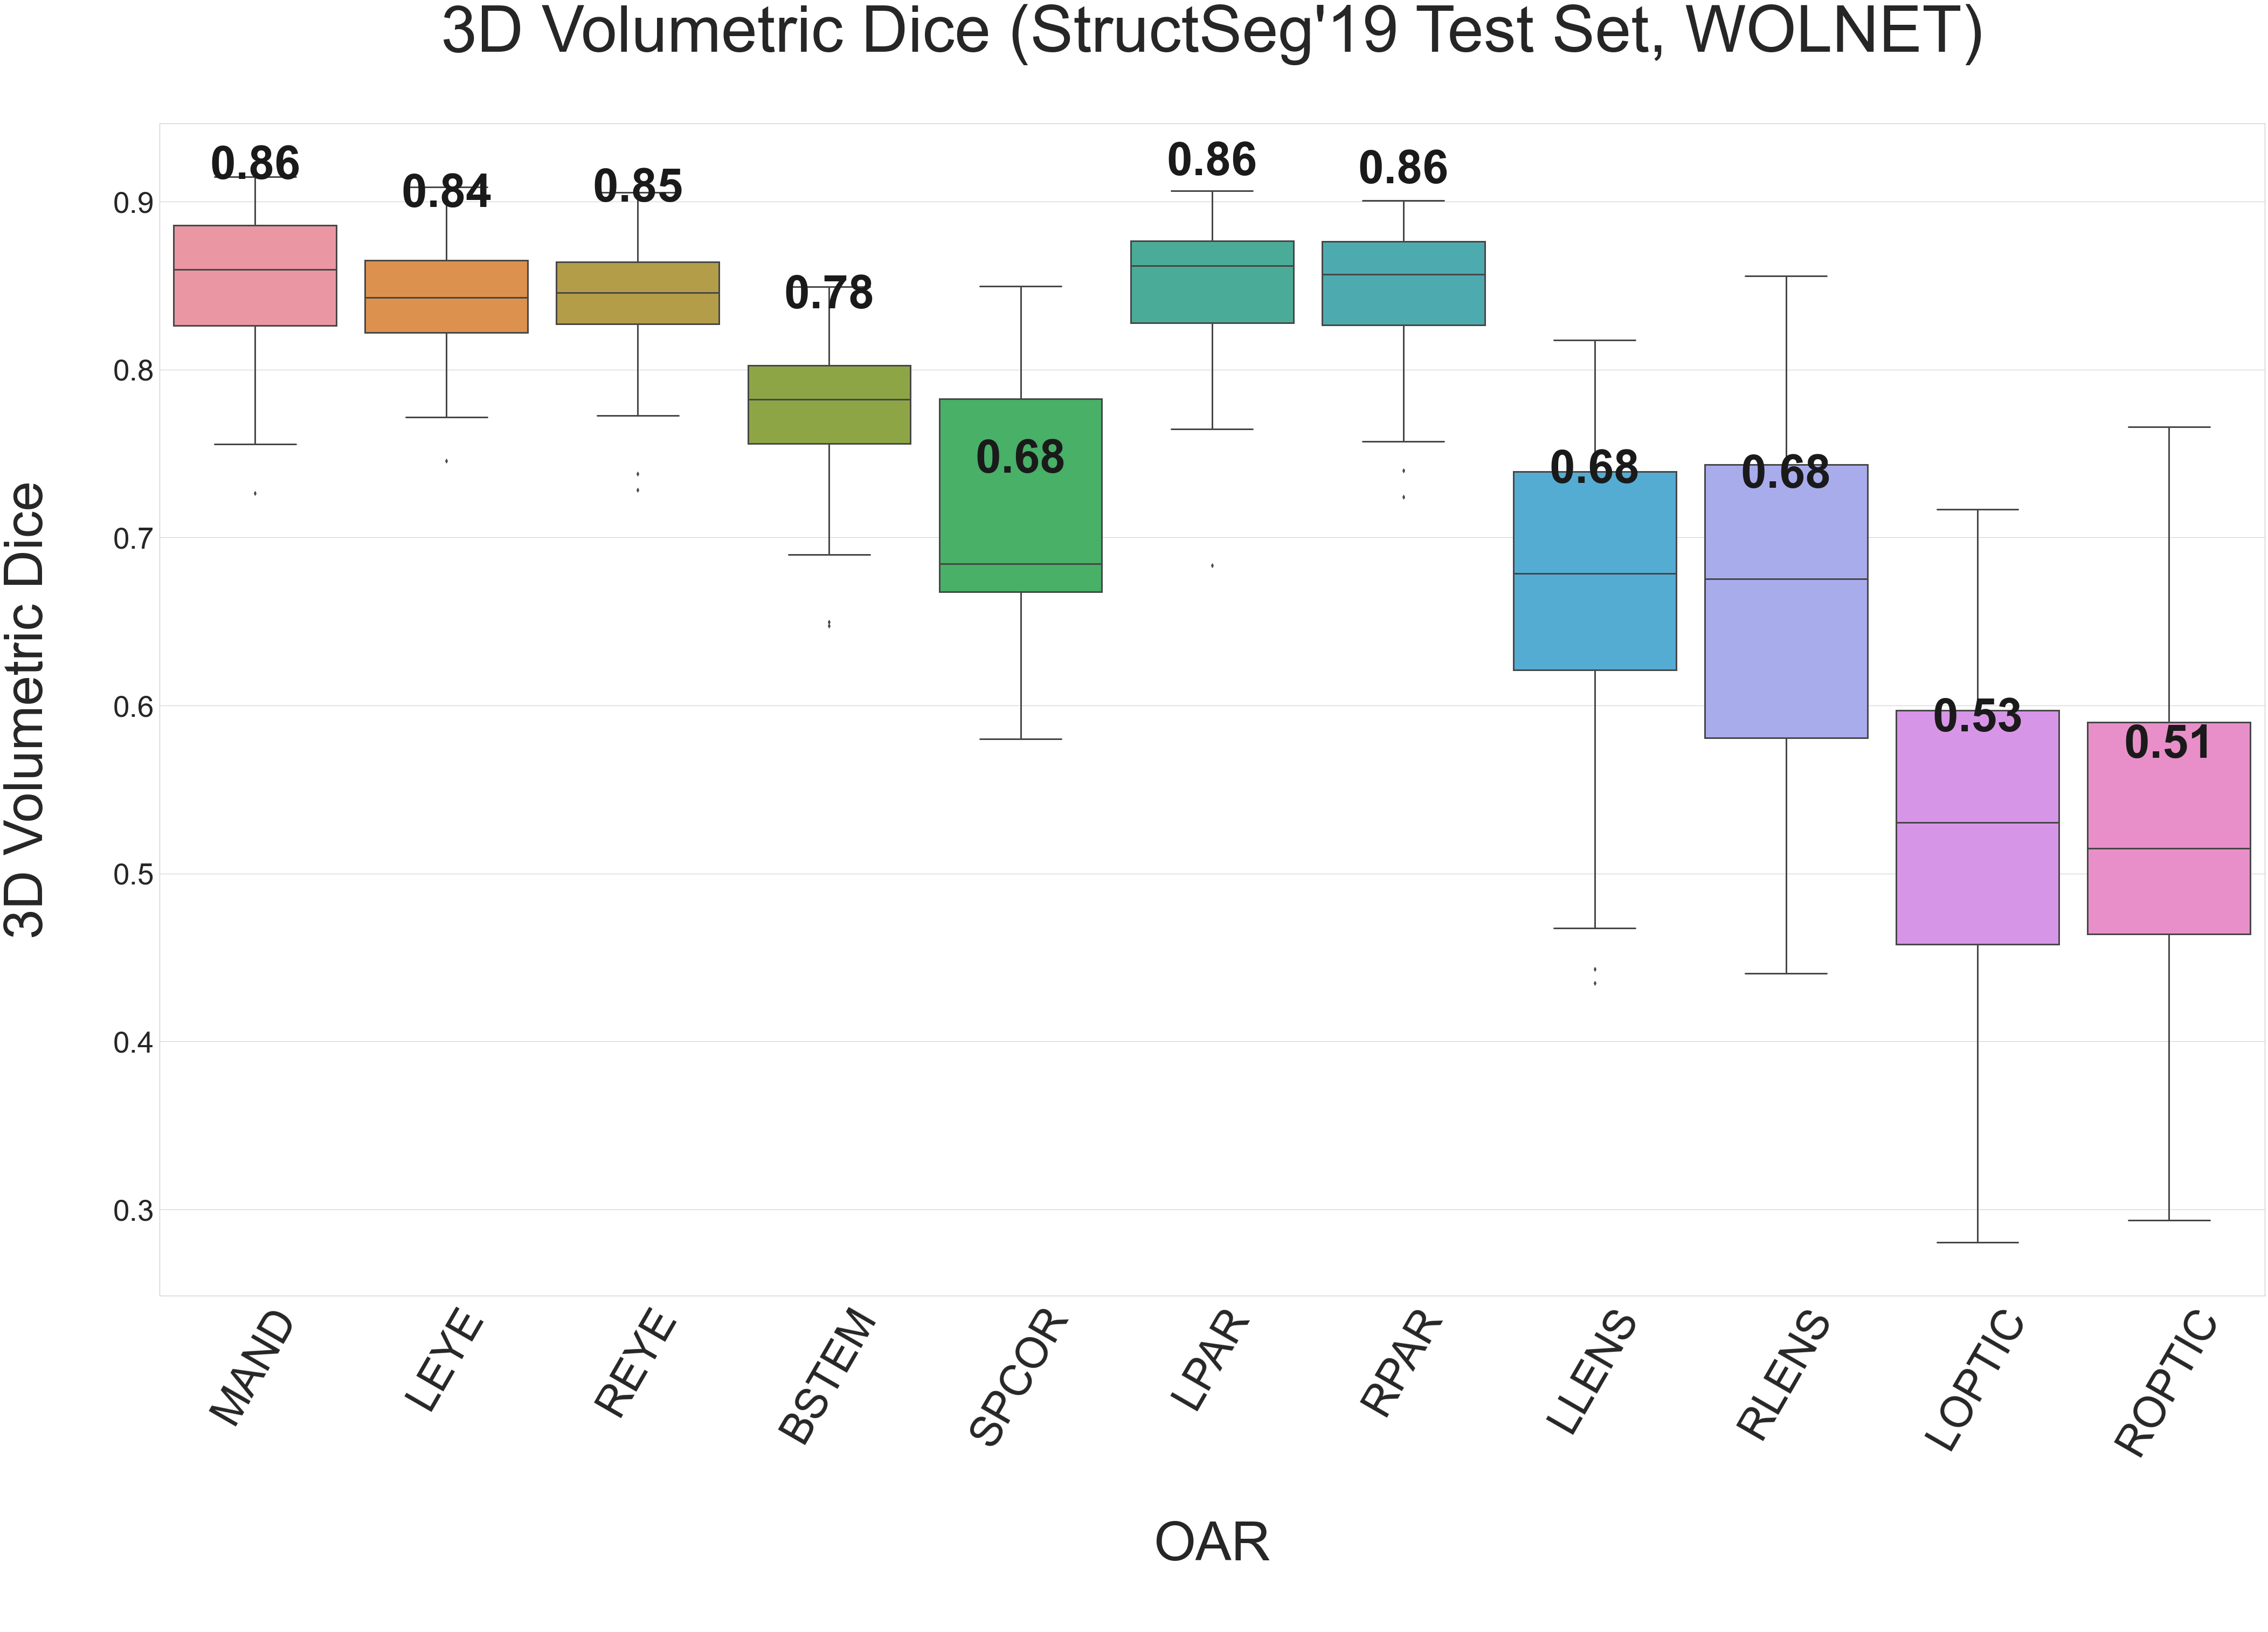

In [68]:
# NOT CORRECTED
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set1")
plt.title('3D Volumetric Dice (StructSeg\'19 Test Set, WOLNET)\n', fontsize=120)
rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'SPCOR', 'LPAR', 'RPAR', 'LLENS', 'RLENS', 'LOPTIC', 'ROPTIC']
# rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'LARYNX', 'SPCOR', 'LPAR', 'RPAR', 'ESOPH', 'LLENS', 'RLENS', 'LACOU', 'RACOU', 'LPLEX', 'RPLEX', 'LIPS', 'LOPTIC', 'ROPTIC', 'CHIASM']
fdata.OAR = fdata.OAR.astype("category")
fdata.OAR.cat.set_categories(rois, inplace=True)
fdata.sort_values(["OAR"])
medians = fdata.groupby(['OAR'])['VolDice'].median()
vertical_offset = fdata['VolDice'].median() * 0.075 # offset from median for display
ax = sea.boxplot(data=fdata, x="OAR", y="VolDice", hue="OAR", width=.85, linewidth=3, dodge=False) # hue_order=chosen,
ax.set_xticklabels(rois, rotation=60, fontsize=80)
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='3D Volumetric Dice\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('3D Volumetric Dice\n', fontsize=100)
ax.legend_.remove()

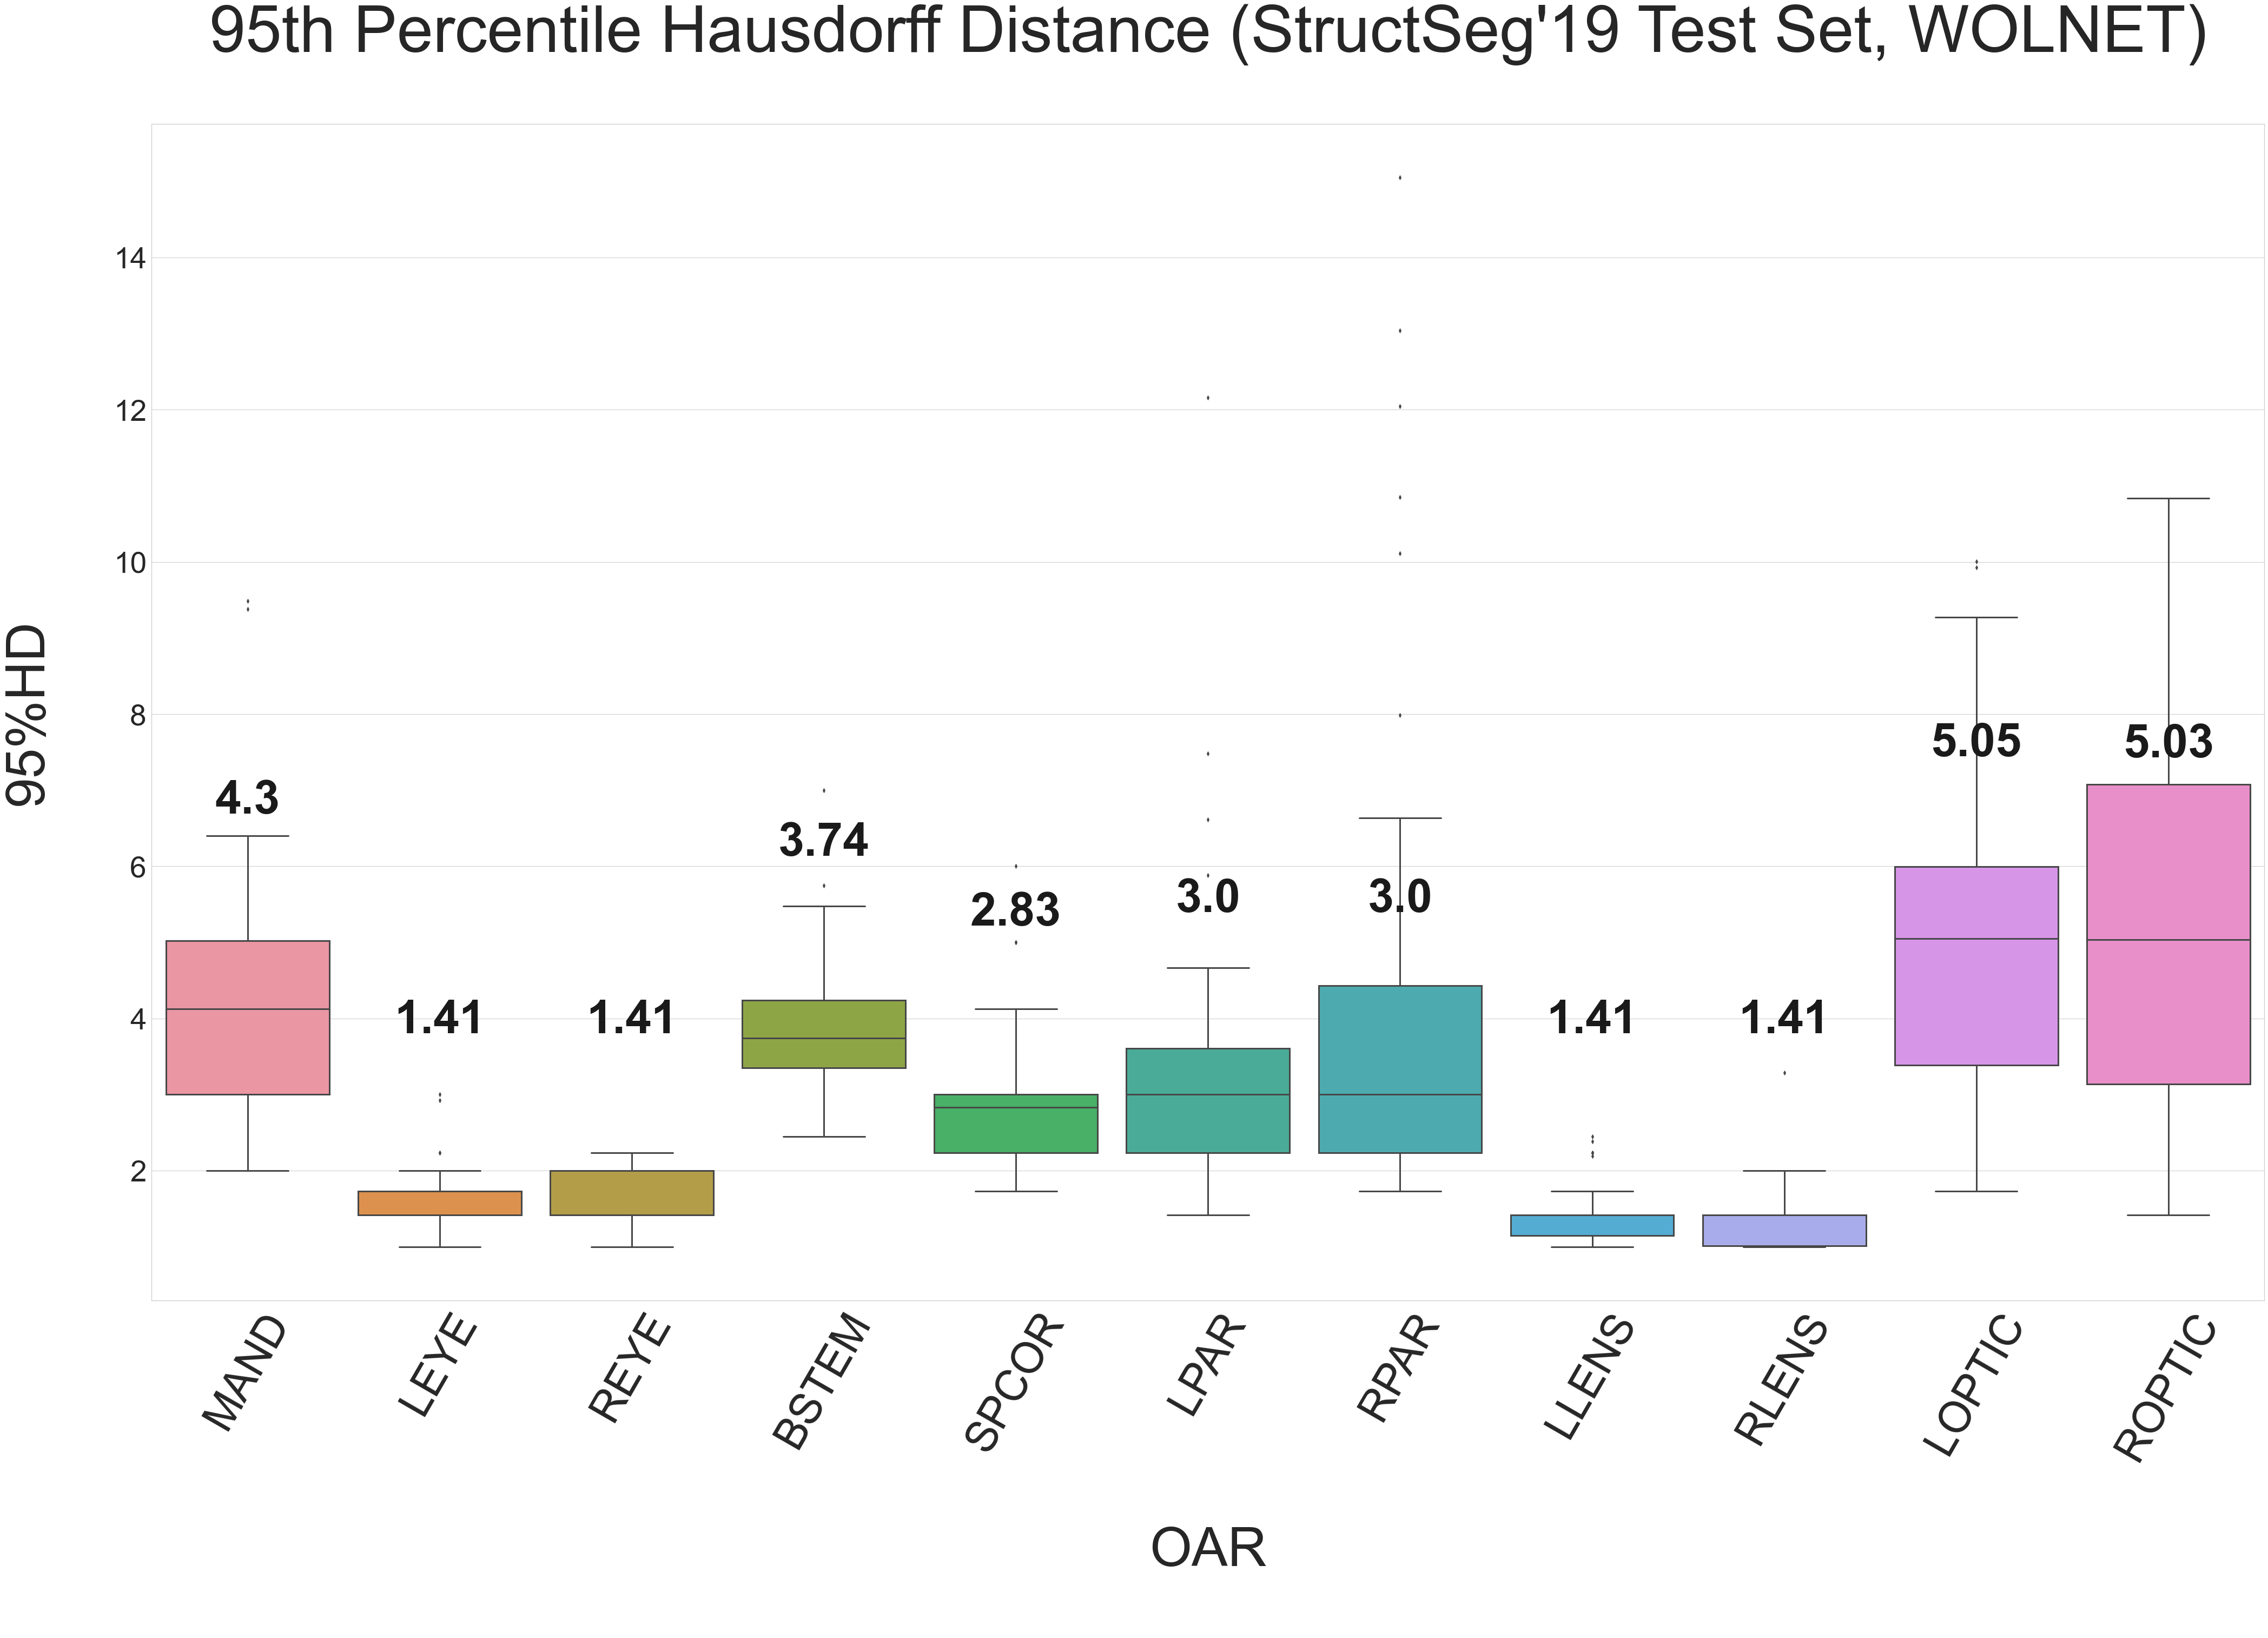

In [69]:
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set2")
plt.title('95th Percentile Hausdorff Distance (StructSeg\'19 Test Set, WOLNET)\n', fontsize=120)
ax = sea.boxplot(data=fdata[fdata["95HD"]<17.5], x="OAR", y="95HD", hue="OAR", width=.85, linewidth=3, dodge=False)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
medians = fdata.groupby(['OAR'])['95HD'].median()
vertical_offset = fdata['95HD'].median() * .8 # offset from median for display
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='95%HD\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('95%HD\n', fontsize=100)
ax.legend_.remove()